In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import equinox as eqx
import diffrax as dfx
import seaborn as sns
import numpy as np

sns.set_theme(style="darkgrid")
palette = "viridis"
sns.set_palette(palette)

In [3]:
from main_g_10 import *
system = BigField(seed =11, num_neurons=40)
#print(init_state)
learned_system = eqx.tree_deserialise_leaves('./models/epoch_2111seed_1val446.5728584138191.eqx', system)
init_state = learned_system.reset(batch_size=5)
print(init_state)


self.steepness:  -7.0
(Array([[-2.04854716,  3.1141222 , -2.35581963, -2.27224193],
       [ 1.97595116,  2.1985907 ,  1.94889813,  2.70879036],
       [-1.12338531,  0.63541949,  0.29595511, -0.64952806],
       [ 0.00979666, -3.06829687,  1.19718232, -3.00573836],
       [-1.65397105,  1.50506407, -2.9999569 , -2.65959035]],      dtype=float64), Array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float64), Array([[-1.7178921 ,  0.76325863, -0.7590417 ,  2.47356767],
       [ 1.50625478, -1.82806717, -0.30750928,  0.86937743],
       [ 2.92026572,  2.88551822, -2.5904787 , -1.91853871],
       [ 3.10889003, -2.82688812, -1.05287969, -2.63113266],
       [-0.5060351 ,  0.99941895,  2.43699531, -0.33663952]],      dtype=float64), Array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float64), Array([[4., 4.],
       [4., 4.],
       [4., 4.],
       [4., 4.],
       [4., 4.]], dtype=float64))


In [4]:
def per_initial_state(bf:BigField, init_state):
    solver = dfx.Tsit5()
    
    obs_a1 = jnp.array([jnp.sin(init_state[0][0]), jnp.cos(init_state[0][0]), init_state[0][1],
                        jnp.sin(init_state[0][2]), jnp.cos(init_state[0][2]), init_state[0][3],
                        init_state[4][0], init_state[4][1], init_state[1][0], 
                        jnp.sin(init_state[2][0]), jnp.cos(init_state[2][0]), init_state[2][1],
                        jnp.sin(init_state[2][2]), jnp.cos(init_state[2][2]), init_state[2][3]])
    obs_a2 = jnp.array([jnp.sin(init_state[2][0]), jnp.cos(init_state[2][0]), init_state[2][1],
                        jnp.sin(init_state[2][2]), jnp.cos(init_state[2][2]), init_state[2][3],
                        init_state[4][0], init_state[4][1], init_state[3][0], 
                        jnp.sin(init_state[0][0]), jnp.cos(init_state[0][0]), init_state[0][1],
                        jnp.sin(init_state[0][2]), jnp.cos(init_state[0][2]), init_state[0][3]])
    
    z_init_a1, z_init_a2 = bf.produce_z(obs_a1, obs_a2)
    init_state_x_z_e_s = (init_state[0], z_init_a1, init_state[1], init_state[2], z_init_a2, init_state[3], init_state[4])
    t0 = 0.0
    t1 = 40.0
    dt0 = 0.04
    ts = jnp.linspace(t0,t1,1000)
    args = None
    saveat = dfx.SaveAt(ts = ts, t1 = True)
    term = dfx.ODETerm(bf.term)
    sol = dfx.diffeqsolve(term,
                          solver,
                          t0,
                          t1,
                          dt0,
                          init_state_x_z_e_s,
                          args,
                          saveat=saveat,
                          stepsize_controller= dfx.PIDController(rtol=1e-3, atol=1e-6), 
                          max_steps=1000000
                          )
    return sol.ys


In [5]:
#sol_ys = jax.vmap(jit_per_initial_state, in_axes=(None, 0))(learned_system, init_state)
sol_ys = jax.vmap(per_initial_state, in_axes=(None,0))(learned_system, init_state)

In [6]:
print(sol_ys.shape)

AttributeError: 'tuple' object has no attribute 'shape'

(5, 1001, 4)
(1001, 4)
(1001,)


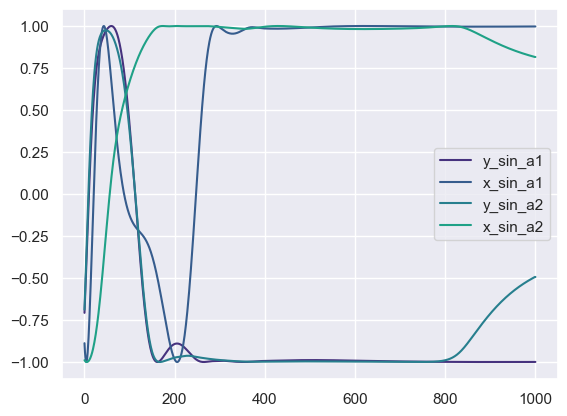

In [7]:
position_data_a1 = sol_ys[0]
print(position_data_a1.shape)
np.save("position_data_a1.npy", position_data_a1)

traj_1_a1 = position_data_a1[0]
print(traj_1_a1.shape)
x_pos = traj_1_a1[:,0]
print(x_pos.shape)
y_pos_a1_sin = jnp.sin(traj_1_a1[:,2])
x_pos_a1_sin = jnp.sin(traj_1_a1[:,0])


position_data_a2 = sol_ys[3]
np.save("position_data_a2.npy", position_data_a2)
traj_1_a2 = position_data_a2[0]
y_pos_a2_sin = jnp.sin(traj_1_a2[:,2])
x_pos_a2_sin = jnp.sin(traj_1_a2[:,0])



plt.plot(y_pos_a1_sin, label="y_sin_a1")
plt.plot(x_pos_a1_sin, label="x_sin_a1")
plt.plot(y_pos_a2_sin, label="y_sin_a2")
plt.plot(x_pos_a2_sin, label="x_sin_a2")
plt.legend()
plt.show()

In [8]:
from main_g_10 import BigField as BigField_10
from main_g_01 import BigField as BigField_01
from main_g_03 import BigField as BigField_03
system_10 = BigField_10(seed =11, num_neurons=40)
system_01 = BigField_01(seed =11, num_neurons=40)
system_03 = BigField_03(seed =11, num_neurons=40)
learned_system_10 = eqx.tree_deserialise_leaves('./models/epoch_2111seed_1val446.5728584138191.eqx', system_10)
learned_system_01 = eqx.tree_deserialise_leaves('./models/epoch_197seed_1val9.402627091105838.eqx', system_01)
learned_system_03 = eqx.tree_deserialise_leaves('./models/epoch_317seed_3val19.77792103931112g_03.eqx', system_03)
init_state = learned_system_01.reset(batch_size=3)

self.steepness:  -7.0
self.steepness:  -7.0
self.steepness:  -7.0


In [9]:
def per_initial_state(bf:BigField, init_state):
    solver = dfx.Tsit5()
    
    obs_a1 = jnp.array([jnp.sin(init_state[0][0]), jnp.cos(init_state[0][0]), init_state[0][1],
                        jnp.sin(init_state[0][2]), jnp.cos(init_state[0][2]), init_state[0][3],
                        init_state[4][0], init_state[4][1], init_state[1][0], 
                        jnp.sin(init_state[2][0]), jnp.cos(init_state[2][0]), init_state[2][1],
                        jnp.sin(init_state[2][2]), jnp.cos(init_state[2][2]), init_state[2][3]])
    obs_a2 = jnp.array([jnp.sin(init_state[2][0]), jnp.cos(init_state[2][0]), init_state[2][1],
                        jnp.sin(init_state[2][2]), jnp.cos(init_state[2][2]), init_state[2][3],
                        init_state[4][0], init_state[4][1], init_state[3][0], 
                        jnp.sin(init_state[0][0]), jnp.cos(init_state[0][0]), init_state[0][1],
                        jnp.sin(init_state[0][2]), jnp.cos(init_state[0][2]), init_state[0][3]])
    
    z_init_a1, z_init_a2 = bf.produce_z(obs_a1, obs_a2)
    init_state_x_z_e_s = (init_state[0], z_init_a1, init_state[1], init_state[2], z_init_a2, init_state[3], init_state[4])
    t0 = 0.0
    t1 = 40.0
    dt0 = 0.04
    ts = jnp.linspace(t0,t1,1000)
    args = None
    saveat = dfx.SaveAt(ts = ts, t1 = True)
    term = dfx.ODETerm(bf.term)
    sol = dfx.diffeqsolve(term,
                          solver,
                          t0,
                          t1,
                          dt0,
                          init_state_x_z_e_s,
                          args,
                          saveat=saveat,
                          stepsize_controller= dfx.PIDController(rtol=1e-3, atol=1e-6), 
                          max_steps=1000000
                          )
    return sol.ys


In [10]:
sol_ys_10 = jax.vmap(per_initial_state, in_axes=(None,0))(learned_system_10, init_state)
sol_ys_01 = jax.vmap(per_initial_state, in_axes=(None,0))(learned_system_01, init_state)
sol_ys_03 = jax.vmap(per_initial_state, in_axes=(None,0))(learned_system_03, init_state)

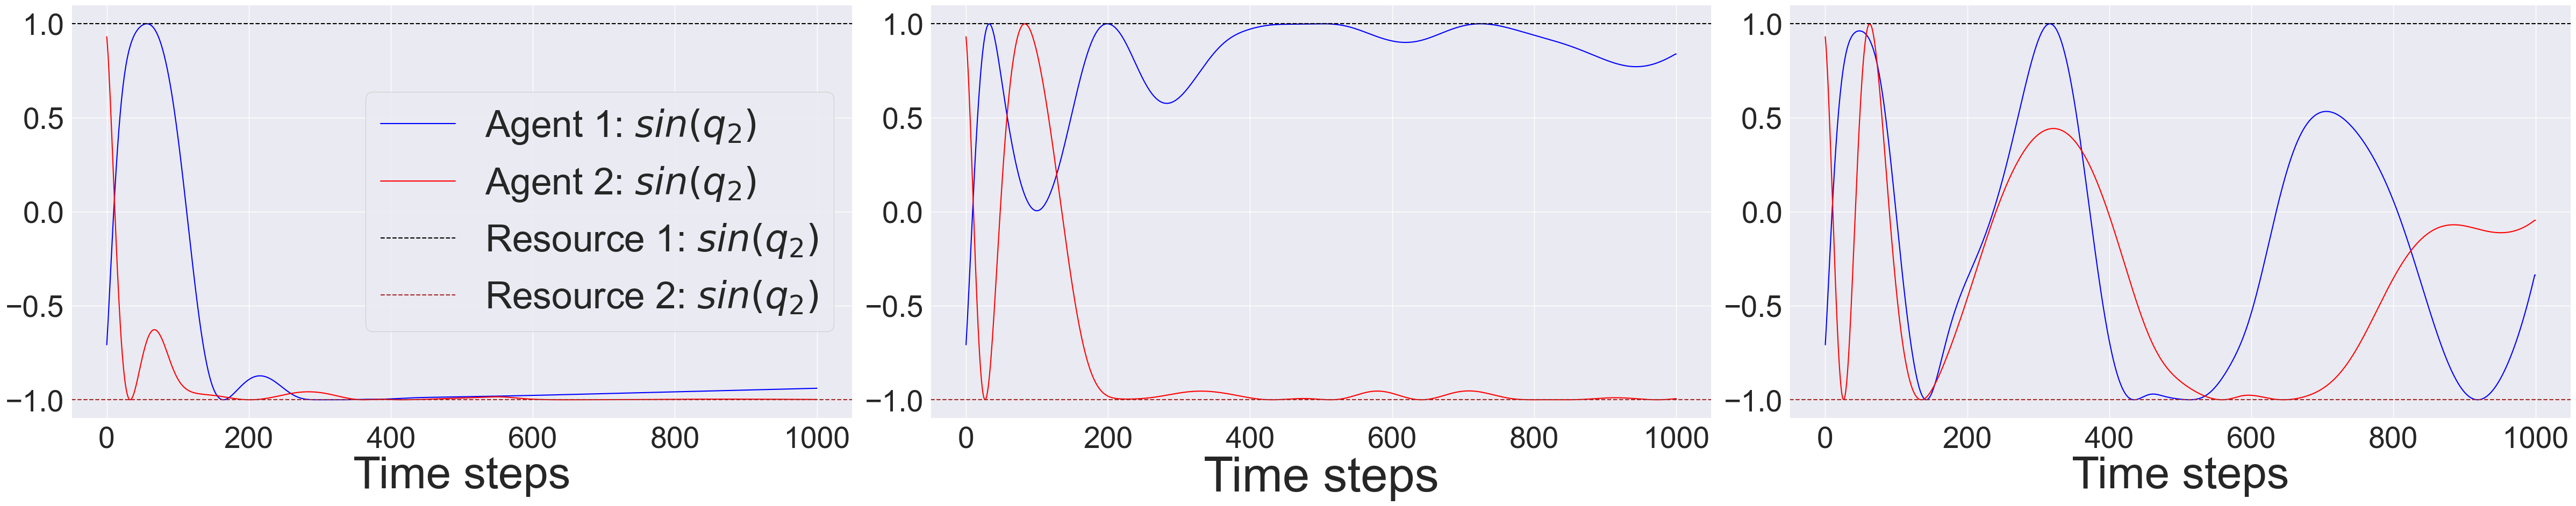

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(60, 10))
plt.subplots_adjust(wspace=0.1)

position_data_a1_g_10 = sol_ys_10[0]
traj_1_a1_g_10 = position_data_a1_g_10[0]
x_pos_a1_g_01_sin = jnp.sin(traj_1_a1_g_10[:,0])
y_pos_a1_g_01_sin = jnp.sin(traj_1_a1_g_10[:,2])

position_data_a2_g_10 = sol_ys_10[3]
traj_1_a2_g_10 = position_data_a2_g_10[0]
x_pos_a2_g_01_sin = jnp.sin(traj_1_a2_g_10[:,0])
y_pos_a2_g_01_sin = jnp.sin(traj_1_a2_g_10[:,2])

axs[0].plot(y_pos_a1_g_01_sin, label="Agent 1: $sin(q_2)$", color='blue')
#axs[0].plot(x_pos_a1_g_01_sin, label="Agent 1: $sin(q_1)$", color='olivedrab')
axs[0].plot(y_pos_a2_g_01_sin, label="Agent 2: $sin(q_2)$", color='red')
#axs[0].plot(x_pos_a2_g_01_sin, label="Agent 2: $sin(q_1)$", color='darkolivegreen')
axs[0].tick_params(axis='x', labelsize=40)
axs[0].tick_params(axis='y', labelsize=40)
axs[0].set_xlabel("Time steps", fontsize=60)
#make a dashed line at y = 1 and y = -1 showing position of resources
axs[0].axhline(y=1, color='black', linestyle='--', label="Resource 1: $sin(q_2)$")
axs[0].axhline(y=-1, color='brown', linestyle='--', label="Resource 2: $sin(q_2)$")
axs[0].legend(fontsize=50)

position_data_a1_g_01 = sol_ys_01[0]
traj_1_a1_g_01 = position_data_a1_g_01[0]
x_pos_a1_g_01_sin = jnp.sin(traj_1_a1_g_01[:,0])
y_pos_a1_g_01_sin = jnp.sin(traj_1_a1_g_01[:,2])

position_data_a2_g_01 = sol_ys_01[3]
traj_1_a2_g_01 = position_data_a2_g_01[0]
x_pos_a2_g_01_sin = jnp.sin(traj_1_a2_g_01[:,0])
y_pos_a2_g_01_sin = jnp.sin(traj_1_a2_g_01[:,2])

axs[1].plot(y_pos_a1_g_01_sin, label="agent1: sin(q2)", color='blue')
#axs[1].plot(x_pos_a1_g_01_sin, label="agent1: sin(q1)", color='olivedrab')
axs[1].plot(y_pos_a2_g_01_sin, label="agent2: sin(q2)", color='red')
#axs[1].plot(x_pos_a2_g_01_sin, label="agent2: sin(q1)", color='darkolivegreen')
axs[1].tick_params(axis='x', labelsize=40)
axs[1].tick_params(axis='y', labelsize=40)
axs[1].set_xlabel("Time steps", fontsize=65)
axs[1].axhline(y=1, color='black', linestyle='--')
axs[1].axhline(y=-1, color='brown', linestyle='--')

position_data_a1_g_03 = sol_ys_03[0]
traj_1_a1_g_03 = position_data_a1_g_03[0]
x_pos_a1_g_03_sin = jnp.sin(traj_1_a1_g_03[:,0])
y_pos_a1_g_03_sin = jnp.sin(traj_1_a1_g_03[:,2])

position_data_a2_g_03 = sol_ys_03[3]
traj_1_a2_g_03 = position_data_a2_g_03[0]
x_pos_a2_g_03_sin = jnp.sin(traj_1_a2_g_03[:,0])
y_pos_a2_g_03_sin = jnp.sin(traj_1_a2_g_03[:,2])


axs[2].plot(y_pos_a1_g_03_sin, color='blue')
#axs[2].plot(x_pos_a1_g_03_sin, label="Agent 1: $\mathregular{sin(q_1)}$", color='olivedrab')
axs[2].plot(y_pos_a2_g_03_sin, color='red')
#axs[2].plot(x_pos_a2_g_03_sin, label="Agent 2: sin(q1)", color='darkolivegreen')
axs[2].tick_params(axis='x', labelsize=40)
axs[2].tick_params(axis='y', labelsize=40)
axs[2].set_xlabel("Time steps", fontsize=60)
axs[2].axhline(y=1, color='black', linestyle='--')
axs[2].axhline(y=-1, color='brown', linestyle='--')

plt.savefig('value_curve.svg', format='svg', bbox_inches='tight')
plt.show()

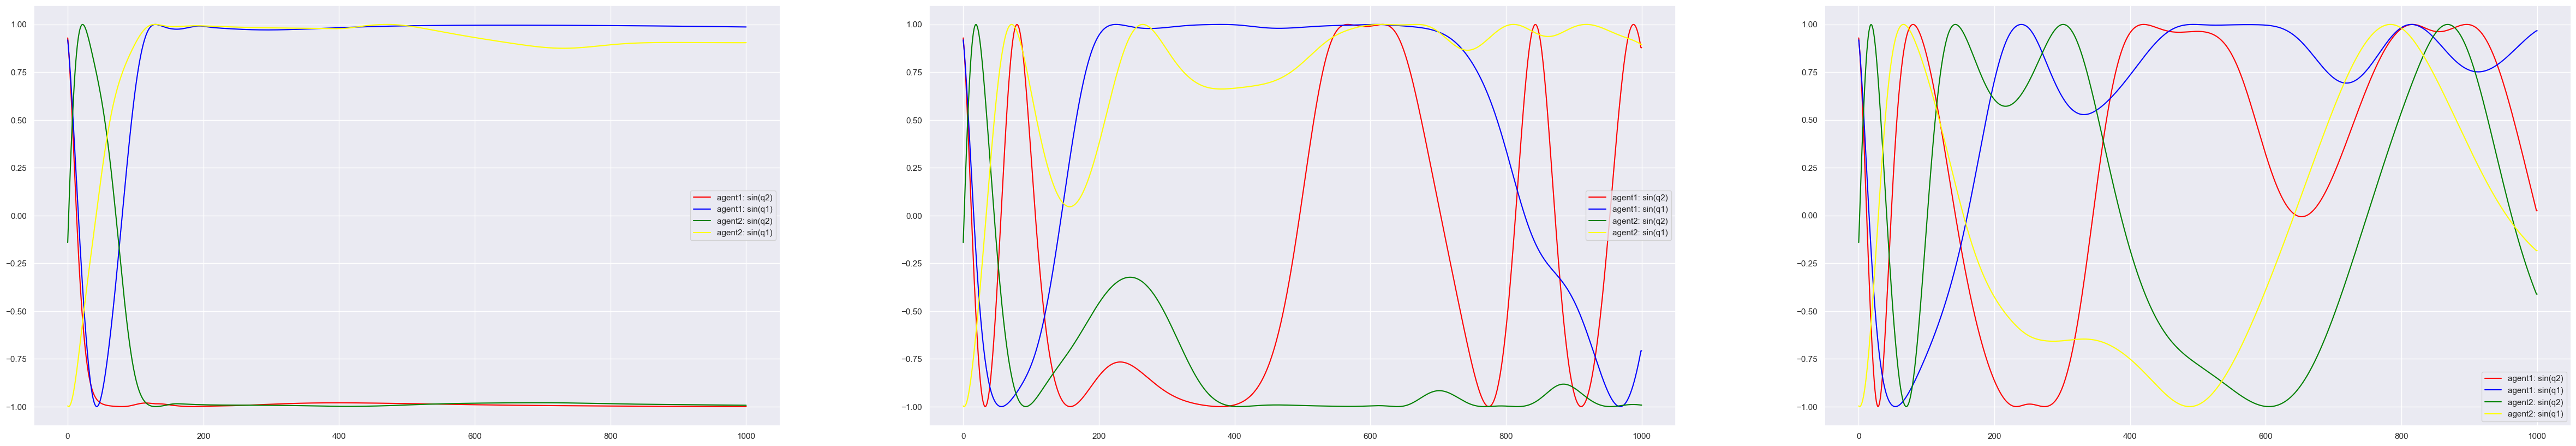

In [175]:
fig, axs = plt.subplots(1, 3, figsize=(60, 10))

position_data_a1_g_10 = sol_ys_10[0]
traj_1_a1_g_10 = position_data_a1_g_10[1]
x_pos_a1_g_01_sin = jnp.sin(traj_1_a1_g_10[:,0])
y_pos_a1_g_01_sin = jnp.sin(traj_1_a1_g_10[:,2])

position_data_a2_g_10 = sol_ys_10[3]
traj_1_a2_g_10 = position_data_a2_g_10[1]
x_pos_a2_g_01_sin = jnp.sin(traj_1_a2_g_10[:,0])
y_pos_a2_g_01_sin = jnp.sin(traj_1_a2_g_10[:,2])

axs[0].plot(y_pos_a1_g_01_sin, label="agent1: sin(q2)", color="red")
axs[0].plot(x_pos_a1_g_01_sin, label="agent1: sin(q1)", color="blue")
axs[0].plot(y_pos_a2_g_01_sin, label="agent2: sin(q2)", color="green")
axs[0].plot(x_pos_a2_g_01_sin, label="agent2: sin(q1)", color="yellow")
axs[0].legend()

position_data_a1_g_01 = sol_ys_01[0]
traj_1_a1_g_01 = position_data_a1_g_01[1]
x_pos_a1_g_01_sin = jnp.sin(traj_1_a1_g_01[:,0])
y_pos_a1_g_01_sin = jnp.sin(traj_1_a1_g_01[:,2])

position_data_a2_g_01 = sol_ys_01[3]
traj_1_a2_g_01 = position_data_a2_g_01[1]
x_pos_a2_g_01_sin = jnp.sin(traj_1_a2_g_01[:,0])
y_pos_a2_g_01_sin = jnp.sin(traj_1_a2_g_01[:,2])

axs[1].plot(y_pos_a1_g_01_sin, label="agent1: sin(q2)", color="red")
axs[1].plot(x_pos_a1_g_01_sin, label="agent1: sin(q1)", color="blue")
axs[1].plot(y_pos_a2_g_01_sin, label="agent2: sin(q2)", color="green")
axs[1].plot(x_pos_a2_g_01_sin, label="agent2: sin(q1)", color="yellow")
axs[1].legend()

position_data_a1_g_03 = sol_ys_03[0]
traj_1_a1_g_03 = position_data_a1_g_03[1]
x_pos_a1_g_03_sin = jnp.sin(traj_1_a1_g_03[:,0])
y_pos_a1_g_03_sin = jnp.sin(traj_1_a1_g_03[:,2])

position_data_a2_g_03 = sol_ys_03[3]
traj_1_a2_g_03 = position_data_a2_g_03[1]
x_pos_a2_g_03_sin = jnp.sin(traj_1_a2_g_03[:,0])
y_pos_a2_g_03_sin = jnp.sin(traj_1_a2_g_03[:,2])

axs[2].plot(y_pos_a1_g_03_sin, label="agent1: sin(q2)", color="red")
axs[2].plot(x_pos_a1_g_03_sin, label="agent1: sin(q1)", color="blue")
axs[2].plot(y_pos_a2_g_03_sin, label="agent2: sin(q2)", color="green")
axs[2].plot(x_pos_a2_g_03_sin, label="agent2: sin(q1)", color="yellow")
axs[2].legend()

plt.legend()
plt.show()

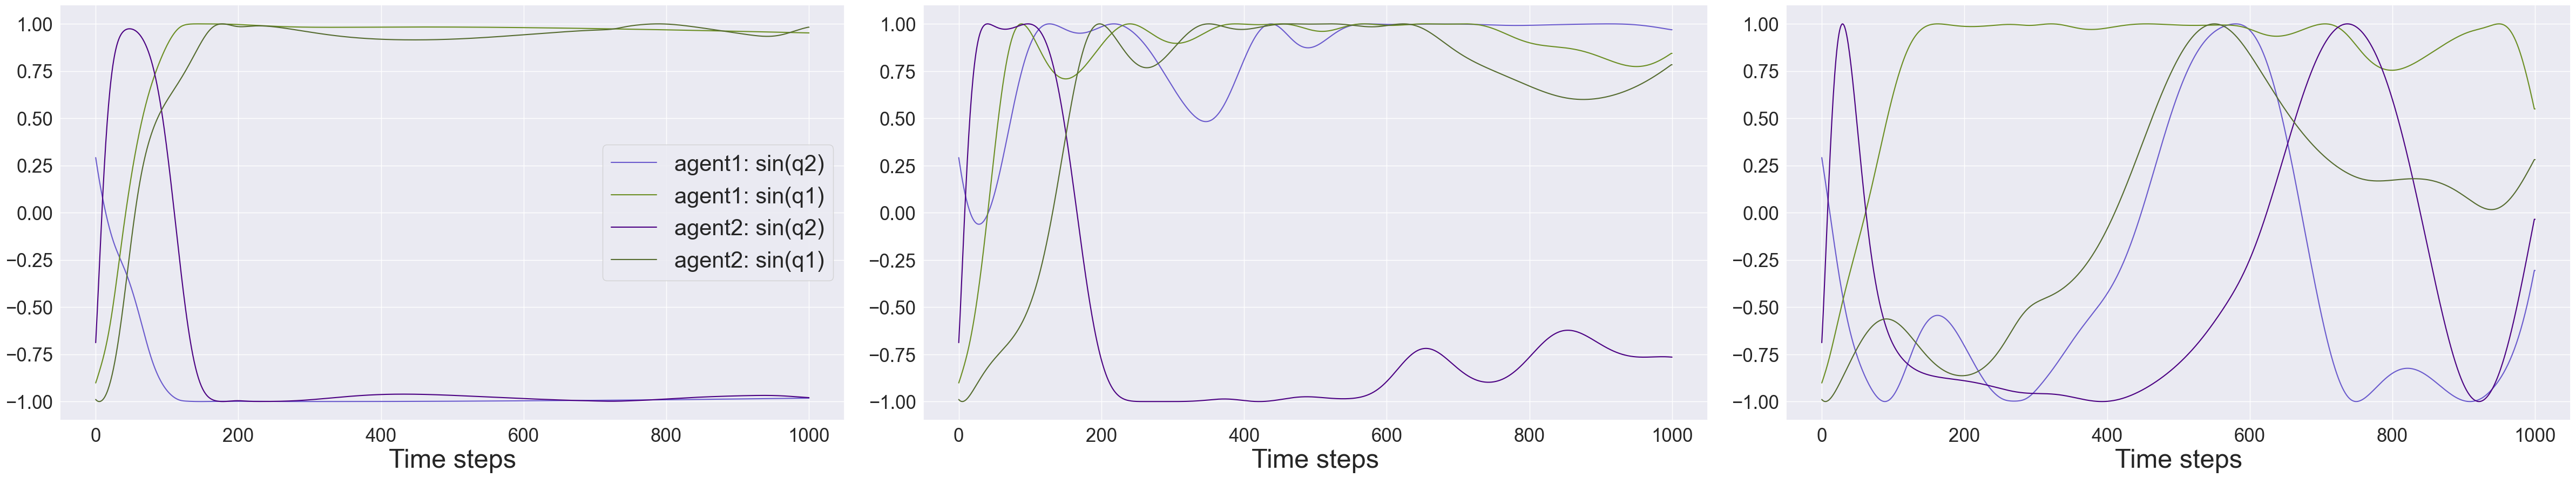

In [180]:
import matplotlib.gridspec as gridspec
fig, axs = plt.subplots(1, 3, figsize=(60, 10))
plt.subplots_adjust(wspace=0.1)


position_data_a1_g_10 = sol_ys_10[0]
traj_1_a1_g_10 = position_data_a1_g_10[2]
x_pos_a1_g_01_sin = jnp.sin(traj_1_a1_g_10[:,0])
y_pos_a1_g_01_sin = jnp.sin(traj_1_a1_g_10[:,2])

position_data_a2_g_10 = sol_ys_10[3]
traj_1_a2_g_10 = position_data_a2_g_10[2]
x_pos_a2_g_01_sin = jnp.sin(traj_1_a2_g_10[:,0])
y_pos_a2_g_01_sin = jnp.sin(traj_1_a2_g_10[:,2])

axs[0].plot(y_pos_a1_g_01_sin, label="agent1: sin(q2)", color="slateblue")
axs[0].plot(x_pos_a1_g_01_sin, label="agent1: sin(q1)", color="olivedrab")
axs[0].plot(y_pos_a2_g_01_sin, label="agent2: sin(q2)", color="indigo")
axs[0].plot(x_pos_a2_g_01_sin, label="agent2: sin(q1)", color="darkolivegreen")
axs[0].tick_params(axis='x', labelsize=25)
axs[0].tick_params(axis='y', labelsize=25)
axs[0].legend(fontsize=30)
axs[0].set_xlabel("Time steps", fontsize=35)

position_data_a1_g_01 = sol_ys_01[0]
traj_1_a1_g_01 = position_data_a1_g_01[2]
x_pos_a1_g_01_sin = jnp.sin(traj_1_a1_g_01[:,0])
y_pos_a1_g_01_sin = jnp.sin(traj_1_a1_g_01[:,2])

position_data_a2_g_01 = sol_ys_01[3]
traj_1_a2_g_01 = position_data_a2_g_01[2]
x_pos_a2_g_01_sin = jnp.sin(traj_1_a2_g_01[:,0])
y_pos_a2_g_01_sin = jnp.sin(traj_1_a2_g_01[:,2])

axs[1].plot(y_pos_a1_g_01_sin, label="agent1: sin(q2)", color="slateblue")
axs[1].plot(x_pos_a1_g_01_sin, label="agent1: sin(q1)", color="olivedrab")
axs[1].plot(y_pos_a2_g_01_sin, label="agent2: sin(q2)", color="indigo")
axs[1].plot(x_pos_a2_g_01_sin, label="agent2: sin(q1)", color="darkolivegreen")
axs[1].tick_params(axis='x', labelsize=25)
axs[1].tick_params(axis='y', labelsize=25)
axs[1].tick_params(axis='x', labelsize=25)
axs[1].tick_params(axis='y', labelsize=25)
axs[1].set_xlabel("Time steps", fontsize=35)


position_data_a1_g_03 = sol_ys_03[0]
traj_1_a1_g_03 = position_data_a1_g_03[2]
x_pos_a1_g_03_sin = jnp.sin(traj_1_a1_g_03[:,0])
y_pos_a1_g_03_sin = jnp.sin(traj_1_a1_g_03[:,2])

position_data_a2_g_03 = sol_ys_03[3]
traj_1_a2_g_03 = position_data_a2_g_03[2]
x_pos_a2_g_03_sin = jnp.sin(traj_1_a2_g_03[:,0])
y_pos_a2_g_03_sin = jnp.sin(traj_1_a2_g_03[:,2])

axs[2].plot(y_pos_a1_g_03_sin, label="agent1: sin(q2)", color="slateblue")
axs[2].plot(x_pos_a1_g_03_sin, label="agent1: sin(q1)", color="olivedrab")
axs[2].plot(y_pos_a2_g_03_sin, label="agent2: sin(q2)", color="indigo")
axs[2].plot(x_pos_a2_g_03_sin, label="agent2: sin(q1)", color="darkolivegreen")
axs[2].tick_params(axis='x', labelsize=25)
axs[2].tick_params(axis='y', labelsize=25)
axs[2].set_xlabel("Time steps", fontsize=35)
plt.show()

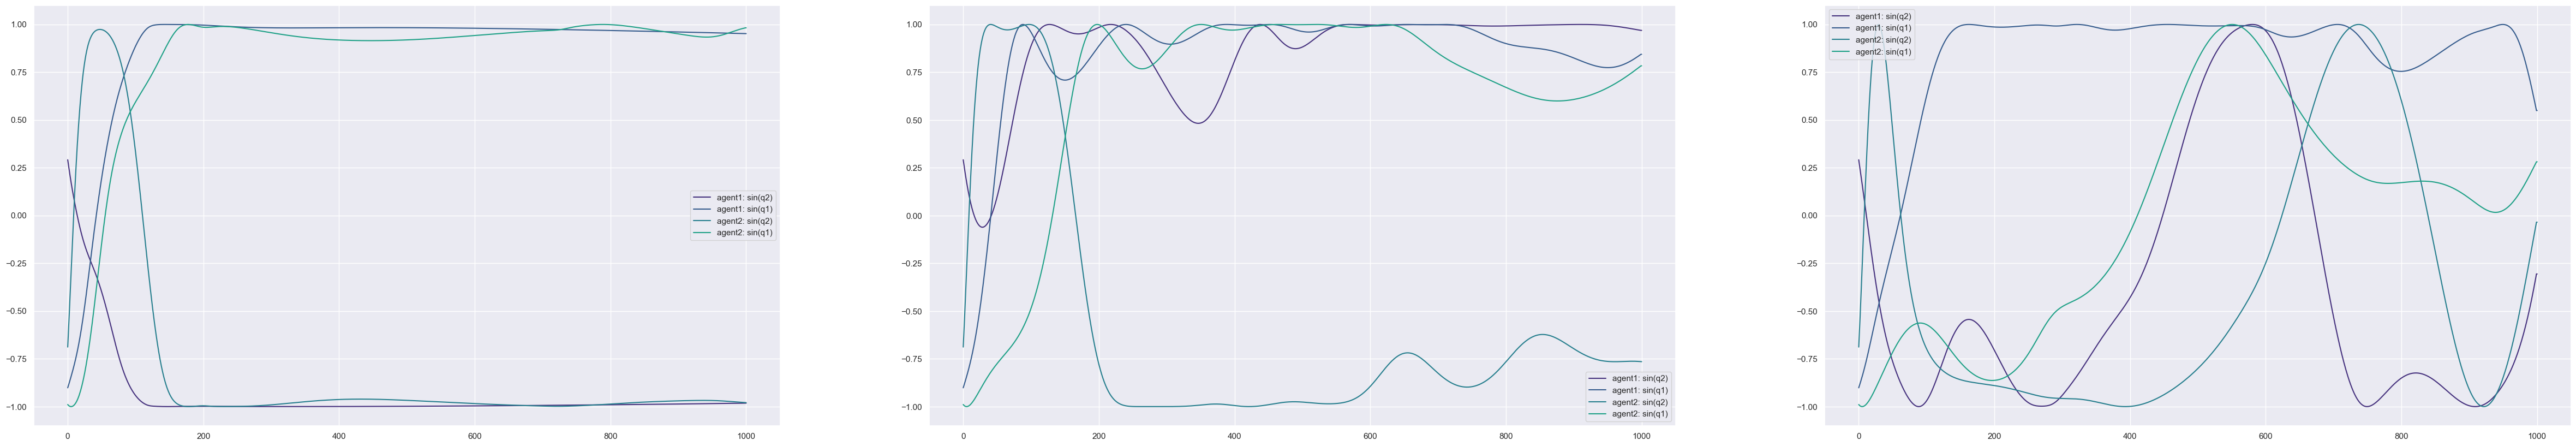

In [144]:
fig, axs = plt.subplots(1, 3, figsize=(60, 10))

position_data_a1_g_10 = sol_ys_10[0]
traj_1_a1_g_10 = position_data_a1_g_10[3]
x_pos_a1_g_01_sin = jnp.sin(traj_1_a1_g_10[:,0])
y_pos_a1_g_01_sin = jnp.sin(traj_1_a1_g_10[:,2])

position_data_a2_g_10 = sol_ys_10[3]
traj_1_a2_g_10 = position_data_a2_g_10[3]
x_pos_a2_g_01_sin = jnp.sin(traj_1_a2_g_10[:,0])
y_pos_a2_g_01_sin = jnp.sin(traj_1_a2_g_10[:,2])

axs[0].plot(y_pos_a1_g_01_sin, label="agent1: sin(q2)")
axs[0].plot(x_pos_a1_g_01_sin, label="agent1: sin(q1)")
axs[0].plot(y_pos_a2_g_01_sin, label="agent2: sin(q2)")
axs[0].plot(x_pos_a2_g_01_sin, label="agent2: sin(q1)")
axs[0].legend()

position_data_a1_g_01 = sol_ys_01[0]
traj_1_a1_g_01 = position_data_a1_g_01[3]
x_pos_a1_g_01_sin = jnp.sin(traj_1_a1_g_01[:,0])
y_pos_a1_g_01_sin = jnp.sin(traj_1_a1_g_01[:,2])

position_data_a2_g_01 = sol_ys_01[3]
traj_1_a2_g_01 = position_data_a2_g_01[3]
x_pos_a2_g_01_sin = jnp.sin(traj_1_a2_g_01[:,0])
y_pos_a2_g_01_sin = jnp.sin(traj_1_a2_g_01[:,2])

axs[1].plot(y_pos_a1_g_01_sin, label="agent1: sin(q2)")
axs[1].plot(x_pos_a1_g_01_sin, label="agent1: sin(q1)")
axs[1].plot(y_pos_a2_g_01_sin, label="agent2: sin(q2)")
axs[1].plot(x_pos_a2_g_01_sin, label="agent2: sin(q1)")
axs[1].legend()

position_data_a1_g_03 = sol_ys_03[0]
traj_1_a1_g_03 = position_data_a1_g_03[3]
x_pos_a1_g_03_sin = jnp.sin(traj_1_a1_g_03[:,0])
y_pos_a1_g_03_sin = jnp.sin(traj_1_a1_g_03[:,2])

position_data_a2_g_03 = sol_ys_03[3]
traj_1_a2_g_03 = position_data_a2_g_03[3]
x_pos_a2_g_03_sin = jnp.sin(traj_1_a2_g_03[:,0])
y_pos_a2_g_03_sin = jnp.sin(traj_1_a2_g_03[:,2])

axs[2].plot(y_pos_a1_g_03_sin, label="agent1: sin(q2)")
axs[2].plot(x_pos_a1_g_03_sin, label="agent1: sin(q1)")
axs[2].plot(y_pos_a2_g_03_sin, label="agent2: sin(q2)")
axs[2].plot(x_pos_a2_g_03_sin, label="agent2: sin(q1)")
axs[2].legend()

plt.legend()
plt.show()

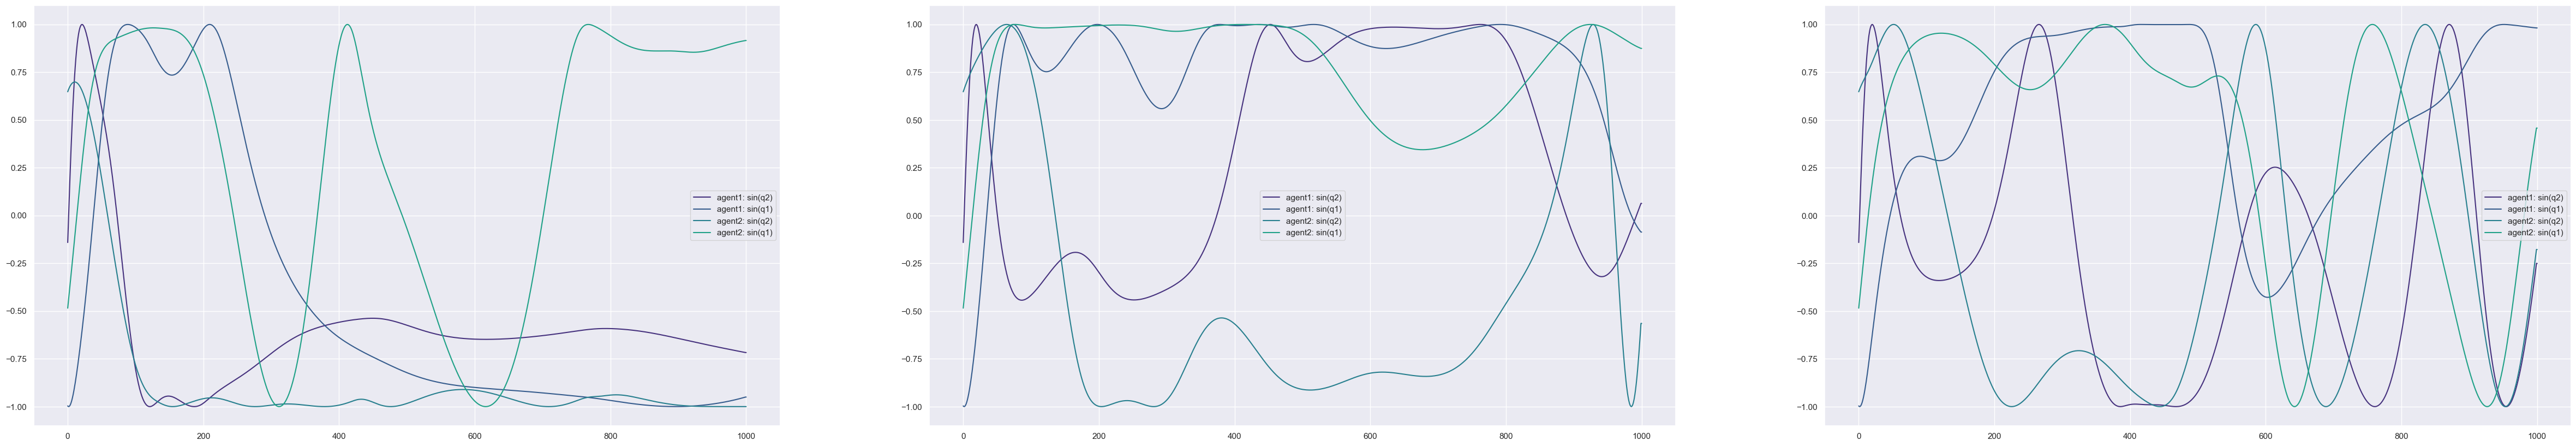

In [136]:
fig, axs = plt.subplots(1, 3, figsize=(60, 10))

position_data_a1_g_10 = sol_ys_10[0]
traj_1_a1_g_10 = position_data_a1_g_10[4]
x_pos_a1_g_01_sin = jnp.sin(traj_1_a1_g_10[:,0])
y_pos_a1_g_01_sin = jnp.sin(traj_1_a1_g_10[:,2])

position_data_a2_g_10 = sol_ys_10[3]
traj_1_a2_g_10 = position_data_a2_g_10[4]
x_pos_a2_g_01_sin = jnp.sin(traj_1_a2_g_10[:,0])
y_pos_a2_g_01_sin = jnp.sin(traj_1_a2_g_10[:,2])

axs[0].plot(y_pos_a1_g_01_sin, label="agent1: sin(q2)")
axs[0].plot(x_pos_a1_g_01_sin, label="agent1: sin(q1)")
axs[0].plot(y_pos_a2_g_01_sin, label="agent2: sin(q2)")
axs[0].plot(x_pos_a2_g_01_sin, label="agent2: sin(q1)")
axs[0].legend()

position_data_a1_g_01 = sol_ys_01[0]
traj_1_a1_g_01 = position_data_a1_g_01[4]
x_pos_a1_g_01_sin = jnp.sin(traj_1_a1_g_01[:,0])
y_pos_a1_g_01_sin = jnp.sin(traj_1_a1_g_01[:,2])

position_data_a2_g_01 = sol_ys_01[3]
traj_1_a2_g_01 = position_data_a2_g_01[4]
x_pos_a2_g_01_sin = jnp.sin(traj_1_a2_g_01[:,0])
y_pos_a2_g_01_sin = jnp.sin(traj_1_a2_g_01[:,2])

axs[1].plot(y_pos_a1_g_01_sin, label="agent1: sin(q2)")
axs[1].plot(x_pos_a1_g_01_sin, label="agent1: sin(q1)")
axs[1].plot(y_pos_a2_g_01_sin, label="agent2: sin(q2)")
axs[1].plot(x_pos_a2_g_01_sin, label="agent2: sin(q1)")
axs[1].legend()

position_data_a1_g_03 = sol_ys_03[0]
traj_1_a1_g_03 = position_data_a1_g_03[4]
x_pos_a1_g_03_sin = jnp.sin(traj_1_a1_g_03[:,0])
y_pos_a1_g_03_sin = jnp.sin(traj_1_a1_g_03[:,2])

position_data_a2_g_03 = sol_ys_03[3]
traj_1_a2_g_03 = position_data_a2_g_03[4]
x_pos_a2_g_03_sin = jnp.sin(traj_1_a2_g_03[:,0])
y_pos_a2_g_03_sin = jnp.sin(traj_1_a2_g_03[:,2])

axs[2].plot(y_pos_a1_g_03_sin, label="agent1: sin(q2)")
axs[2].plot(x_pos_a1_g_03_sin, label="agent1: sin(q1)")
axs[2].plot(y_pos_a2_g_03_sin, label="agent2: sin(q2)")
axs[2].plot(x_pos_a2_g_03_sin, label="agent2: sin(q1)")
axs[2].legend()

plt.legend()
plt.show()